In [4]:
import os
import sys
import torch as ch
import numpy as np
import cv2
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
from matplotlib import image
import matplotlib.pyplot as plt
from robustness import model_utils
from torchvision import datasets, models
from robustness.tools.vis_tools import show_image_column
from robustness.model_utils import make_and_restore_model
from tools.custom_datasets import CIFAR100, MNIST, SVHN
from robustness.datasets import ImageNet
from torch.utils.data import Dataset
import tools.custom_datasets as custom_datasets
from numpy import asarray
%matplotlib inline

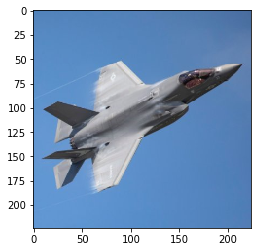

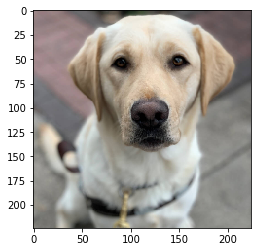

Files already downloaded and verified


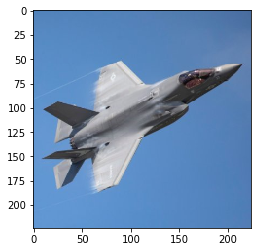

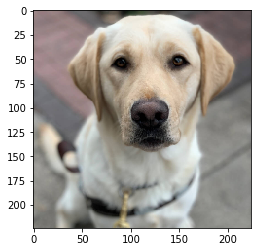

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [10]:
class CustomDataset(Dataset):

    def __init__(self, size, display_images = False):

        self.image_name_list = np.array(['f35', 'dog1'])
        
        self.image_name_to_class_dict = {'boat1':8, 'f35':0, 'dog1':5}
        
        images_directory = "images"
        
        
        self.images = np.empty((len(self.image_name_list), size[0], size[1], 3))
        
        
        for i in range(len(self.image_name_list)):
            image_name = self.image_name_list[i]
            unscaled_image = cv2.imread(f'{images_directory}/{image_name}.jpg')
            scaled_image = cv2.resize(unscaled_image, dsize = size)
            color_corrected_image = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2RGB)
        
            self.images[i, :, :, :] =  color_corrected_image/255

            if display_images:
                plt.imshow(self.images[i,:,:,:])
                plt.show()

    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        
        if ch.is_tensor(idx):
            idx = idx.tolist()
            
        return (ch.from_numpy(np.moveaxis(self.images[idx, :, :, :], [0,1,2], [1,2,0])).float(), self.image_name_to_class_dict[self.image_name_list[idx]])
    
dataset = CustomDataset((224,224), display_images = True)
plt.show()

test_set_old = datasets.CIFAR10(root='/tmp', train=False, download=True,
                             transform=custom_datasets.TRAIN_TRANSFORMS_PIXELATE(size))

test_set = CustomDataset(size, display_images = True)

print(test_set_old[0][0].shape)
print(test_set[0][0].shape)

test_loader = ch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_iterator = enumerate(test_loader)

In [11]:
# Constants
BATCH_SIZE = 4
NUM_WORKERS = 8
NOISE_SCALE = 20
size = (224, 224)

source_model_path_non_transferred_robust = '../models/imagenet_l2_3_0.pt'

source_model_path_transferred_robust = '../models/3eps_to_cifar10_0ul.pt'
source_model_path_transferred_non_robust = '../models/nat_to_cifar10_0ul.pt'

REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

In [13]:
# Load model
model_transferred_robust, _ = make_and_restore_model(arch='resnet50_m', dataset=ImageNet('/tmp'), 
                                  resume_path=source_model_path_transferred_robust, parallel=False)
model_transferred_non_robust, _ = make_and_restore_model(arch='resnet50_m', dataset=ImageNet('/tmp'), 
                                  resume_path=source_model_path_transferred_non_robust, parallel=False)

model_non_transferred_robust, _ = make_and_restore_model(arch='resnet50', dataset=ImageNet('/tmp'), 
                                  resume_path=source_model_path_non_transferred_robust, parallel=False)
model_non_transferred_non_robust, _ = make_and_restore_model(arch='resnet50', dataset=ImageNet('/tmp'), parallel=False, pytorch_pretrained=True)

criterion = ch.nn.CrossEntropyLoss()
for m in [model_transferred_robust, model_transferred_non_robust,
          model_non_transferred_robust, model_non_transferred_non_robust]:
    m.eval()

=> loading checkpoint 'models/3eps_to_cifar10_0ul.pt'
=> loaded checkpoint 'models/3eps_to_cifar10_0ul.pt' (epoch 150)
=> loading checkpoint 'models/nat_to_cifar10_0ul.pt'
=> loaded checkpoint 'models/nat_to_cifar10_0ul.pt' (epoch 150)
=> loading checkpoint 'models/imagenet_l2_3_0.pt'
=> loaded checkpoint 'models/imagenet_l2_3_0.pt' (epoch 105)


In [14]:
# Custom loss to maximize a given component of the representation vector
def feature_vis_loss(model, inp, targ):
    _, rep = model(inp, 
                   with_latent=True, 
                   fake_relu=True) #To propagate gradients through the "zero-region" of a ReLU activation
    loss = rep[:, targ]
    return loss, None

In [15]:
# PGD parameters
kwargs_transferred_natural = {
    'custom_loss': feature_vis_loss,
    'constraint':'2',
    'eps':1000,
    'step_size': 2,
    'iterations':1000,
    'use_best': True
}

kwargs_non_transferred_natural = {
    'custom_loss': feature_vis_loss,
    'constraint':'2',
    'eps':1000,
    'step_size': 2,
    'iterations':1000,
    'use_best': True
}

kwargs_transferred_robust = {
    'custom_loss': feature_vis_loss,
    'constraint':'2',
    'eps':1000,
    'step_size': 2,
    'iterations':1000,
    'use_best': True
}

kwargs_non_transferred_robust = {
    'custom_loss': feature_vis_loss,
    'constraint':'2',
    'eps':1000,
    'step_size': 2,
    'iterations':1000,
    'use_best': True
}

In [16]:
# Seed image for feature visualization (1/2 test images, 1/2 noise)
_, (im, targ) = next(data_iterator)
im_n = ch.randn_like(im) / NOISE_SCALE + 0.5
ims = ch.cat([im, im_n])

image_index_to_label = {0:'boat', 1:'plane', 2:'dog', 3:'boat_noise', 4:'plane_noise', 5:'dog_noise'}

act_list = [4,7,8,29,38,46,52,85,95]
act_list.insert(0, -1)
dpi = 600

labels_to_show = ['dog', 'plane', 'dog_noise']

## Feature viz

10/10: : 10it [05:37, 33.74s/it]


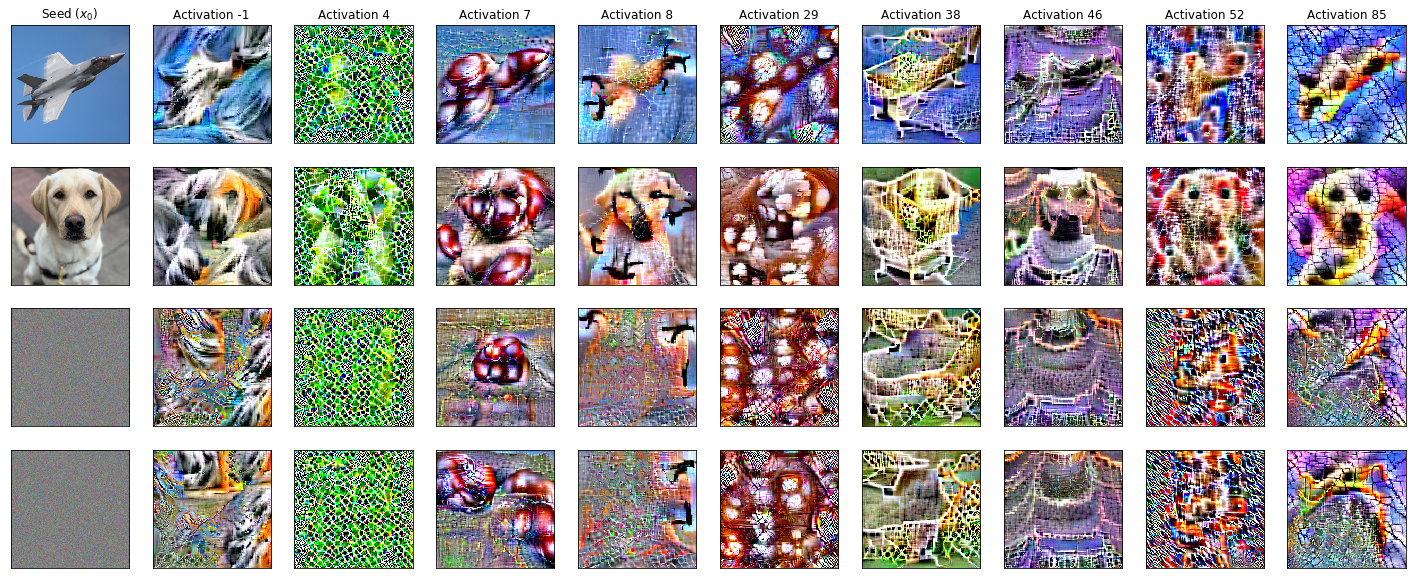

{(-1, 'dog'): tensor([[[0.3137, 0.3098, 0.3176,  ..., 0.2824, 0.2824, 0.2863],
         [0.3137, 0.3098, 0.3176,  ..., 0.2824, 0.2824, 0.2824],
         [0.3137, 0.3137, 0.3176,  ..., 0.2824, 0.2824, 0.2863],
         ...,
         [0.3765, 0.3765, 0.3804,  ..., 0.3216, 0.3216, 0.3176],
         [0.3725, 0.3725, 0.3765,  ..., 0.3216, 0.3216, 0.3176],
         [0.3765, 0.3765, 0.3765,  ..., 0.3216, 0.3216, 0.3176]],

        [[0.5059, 0.5020, 0.5098,  ..., 0.4235, 0.4235, 0.4235],
         [0.5059, 0.5020, 0.5098,  ..., 0.4235, 0.4235, 0.4235],
         [0.5059, 0.5059, 0.5098,  ..., 0.4235, 0.4235, 0.4235],
         ...,
         [0.5882, 0.5882, 0.5922,  ..., 0.4902, 0.4902, 0.4863],
         [0.5843, 0.5843, 0.5882,  ..., 0.4902, 0.4902, 0.4863],
         [0.5882, 0.5882, 0.5882,  ..., 0.4902, 0.4902, 0.4863]],

        [[0.7255, 0.7216, 0.7294,  ..., 0.6196, 0.6196, 0.6235],
         [0.7255, 0.7216, 0.7294,  ..., 0.6196, 0.6196, 0.6235],
         [0.7255, 0.7255, 0.7294,  ..., 0.61

In [17]:
# select the model that you want to use
gpu_model_transferred_robust = model_transferred_robust.cuda()

result_dict = {}

result = [ims.cpu()]

seed_images = result[0]

for i in range(len(labels_to_show)):
    result_dict[(-1, labels_to_show[i])] = seed_images[i,:,:,:]

device = ch.device('cuda')


it = tqdm(enumerate(act_list))
for ii, i in it:
    if i != -1:
        it.set_description(f'{ii+1}/{len(act_list)}')
        _, xadv = gpu_model_transferred_robust(ims.clone().cuda(), i, make_adv=True, **kwargs_transferred_robust)
        adv_images = xadv.detach().cpu()
        for j in range(len(labels_to_show)):
            result_dict[(i, labels_to_show[j])] = adv_images[j,:,:,:]
        result.append(xadv.detach().cpu())
    
# Feature Visualization results: Columns show seed image followed by result of maximizing specific feature
show_image_column(result, 
                  [r'Seed ($x_0$)'] + [f'Activation {i}' for i in act_list])

print(result_dict)

num_cols = len(act_list)
num_rows = len(labels_to_show)

mosaic_array = np.zeros((3, num_rows*224, num_cols*224))

for j in range(num_rows):
    for i in range(num_cols):
        mosaic_array[:, j*224:(j+1)*224, i*224:(i+1)*224] = result_dict[(act_list[i], labels_to_show[j])].numpy()